In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json


In [2]:
cards_df = pd.read_csv('cards_data.csv')
trans_df = pd.read_csv('transactions_data.csv')
users_df = pd.read_csv('users_data.csv')

In [3]:
with open('mcc_codes.json', 'r') as f:
    mcc_data = json.load(f)

with open('train_fraud_labels.json', 'r') as f:
    fraud_labels = json.load(f)

label_data = fraud_labels["target"]

In [4]:
print('User Columns:', users_df.columns)
print('-'*100)
print('Cards Columns:', cards_df.columns)
print('-'*100)
print('Transactions Columns:', trans_df.columns)
print('-'*100)

User Columns: Index(['id', 'current_age', 'retirement_age', 'birth_year', 'birth_month',
       'gender', 'address', 'latitude', 'longitude', 'per_capita_income',
       'yearly_income', 'total_debt', 'credit_score', 'num_credit_cards'],
      dtype='object')
----------------------------------------------------------------------------------------------------
Cards Columns: Index(['id', 'client_id', 'card_brand', 'card_type', 'card_number', 'expires',
       'cvv', 'has_chip', 'num_cards_issued', 'credit_limit', 'acct_open_date',
       'year_pin_last_changed', 'card_on_dark_web'],
      dtype='object')
----------------------------------------------------------------------------------------------------
Transactions Columns: Index(['id', 'date', 'client_id', 'card_id', 'amount', 'use_chip',
       'merchant_id', 'merchant_city', 'merchant_state', 'zip', 'mcc',
       'errors'],
      dtype='object')
-----------------------------------------------------------------------------------------

In [5]:
print('User Data Types:', users_df.dtypes)
print('-'*100)
print('Cards Data Types:', cards_df.dtypes)
print('-'*100)
print('Transactions Data Types:', trans_df.dtypes)
print('-'*100)

User Data Types: id                     int64
current_age            int64
retirement_age         int64
birth_year             int64
birth_month            int64
gender                object
address               object
latitude             float64
longitude            float64
per_capita_income     object
yearly_income         object
total_debt            object
credit_score           int64
num_credit_cards       int64
dtype: object
----------------------------------------------------------------------------------------------------
Cards Data Types: id                        int64
client_id                 int64
card_brand               object
card_type                object
card_number               int64
expires                  object
cvv                       int64
has_chip                 object
num_cards_issued          int64
credit_limit             object
acct_open_date           object
year_pin_last_changed     int64
card_on_dark_web         object
dtype: object
--------------

In [6]:
print('User Null Values:', users_df.isna().sum())
print('-'*100)
print('Cards Null Values:', cards_df.isna().sum())
print('-'*100)
print('Transactions Null Values:', trans_df.isna().sum())
print('-'*100)

User Null Values: id                   0
current_age          0
retirement_age       0
birth_year           0
birth_month          0
gender               0
address              0
latitude             0
longitude            0
per_capita_income    0
yearly_income        0
total_debt           0
credit_score         0
num_credit_cards     0
dtype: int64
----------------------------------------------------------------------------------------------------
Cards Null Values: id                       0
client_id                0
card_brand               0
card_type                0
card_number              0
expires                  0
cvv                      0
has_chip                 0
num_cards_issued         0
credit_limit             0
acct_open_date           0
year_pin_last_changed    0
card_on_dark_web         0
dtype: int64
----------------------------------------------------------------------------------------------------
Transactions Null Values: id                       0
date     

## Data Cleaning on Transaction Data

In [7]:
trans_df['errors'].unique()

array([nan, 'Technical Glitch', 'Bad Expiration', 'Bad Card Number',
       'Insufficient Balance', 'Bad PIN', 'Bad CVV', 'Bad Zipcode',
       'Insufficient Balance,Technical Glitch',
       'Bad PIN,Insufficient Balance', 'Bad PIN,Technical Glitch',
       'Bad Expiration,Technical Glitch',
       'Bad Card Number,Bad Expiration',
       'Bad Card Number,Insufficient Balance',
       'Bad Expiration,Insufficient Balance', 'Bad Card Number,Bad CVV',
       'Bad CVV,Technical Glitch', 'Bad Expiration,Bad CVV',
       'Bad CVV,Insufficient Balance', 'Bad Card Number,Technical Glitch',
       'Bad Zipcode,Insufficient Balance',
       'Bad Card Number,Bad Expiration,Insufficient Balance',
       'Bad Zipcode,Technical Glitch'], dtype=object)

In [9]:
trans_df['errors'].value_counts()

errors
Insufficient Balance                                   130902
Bad PIN                                                 32119
Technical Glitch                                        26271
Bad Card Number                                          7767
Bad Expiration                                           6161
Bad CVV                                                  6106
Bad Zipcode                                              1126
Bad PIN,Insufficient Balance                              293
Insufficient Balance,Technical Glitch                     243
Bad Card Number,Insufficient Balance                       71
Bad PIN,Technical Glitch                                   70
Bad CVV,Insufficient Balance                               57
Bad Expiration,Insufficient Balance                        47
Bad Card Number,Bad CVV                                    38
Bad Card Number,Bad Expiration                             33
Bad Expiration,Bad CVV                                     32
B

In [10]:
print('Null percentage in errors column:', str(round((trans_df['errors'].isna().sum()/trans_df.shape[0])*100,2))+'%')

Null percentage in errors column: 98.41%


- We have 98.4% of null values in the 'errors' column
- We can utilize existing error messages and create new columns based on assumptions

In [ ]:
# Let's create Binary column whether it has error message or not --- "has_error"

trans_df['has_error'] = trans_df['errors'].notnull().astype(int)


- Let's assume,  there is a less chance of user making a mistake in typing these values: Bad PIN, Bad Card Number, Bad Expiration, Bad CVV, Bad Zipcode
- We can consider these values as 'suspicious_error'

In [17]:
suspicious = ['Bad PIN', 'Bad Card Number', 'Bad CVV', 'Bad Expiration', 'Bad Zipcode']
trans_df['suspicious_error'] = trans_df['errors'].apply(lambda x: 1 if isinstance(x, str) and any(err in x for err in suspicious) else 0)


In [19]:
trans_df.head(2)

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,mcc_name,fraud_label,has_error,suspicious_error
0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN,Miscellaneous Food Stores,No,0,0
1,7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN,Department Stores,No,0,0


In [20]:
trans_df['mcc'] = trans_df['mcc'].astype(str)
trans_df['mcc_name'] = trans_df['mcc'].map(mcc_data)

trans_df['id'] = trans_df['id'].astype(str)
trans_df['fraud_label'] = trans_df['id'].map(label_data)
trans_df.head()

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,mcc_name,fraud_label,has_error,suspicious_error
0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN,Miscellaneous Food Stores,No,0,0
1,7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN,Department Stores,No,0,0
2,7475329,2010-01-01 00:02:00,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,NaN,Money Transfer,No,0,0
3,7475331,2010-01-01 00:05:00,430,2860,$200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,4829,NaN,Money Transfer,NaN,0,0
4,7475332,2010-01-01 00:06:00,848,3915,$46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,NaN,Drinking Places (Alcoholic Beverages),No,0,0


In [24]:
trans_df = trans_df[trans_df['fraud_label'].notnull()]

In [27]:
trans_df.to_csv('preprocessed_transaction_data.csv')

In [3]:
trans_df = pd.read_csv('preprocessed_transaction_data.csv')

In [4]:
trans_df.head()

,Unnamed: 0,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,mcc_name,fraud_label,has_error,suspicious_error
0,0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN,Miscellaneous Food Stores,No,0,0
1,1,7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN,Department Stores,No,0,0
2,2,7475329,2010-01-01 00:02:00,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,NaN,Money Transfer,No,0,0
3,4,7475332,2010-01-01 00:06:00,848,3915,$46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,NaN,Drinking Places (Alcoholic Beverages),No,0,0
4,5,7475333,2010-01-01 00:07:00,1807,165,$4.81,Swipe Transaction,20519,Bronx,NY,10464.0,5942,NaN,Book Stores,No,0,0


In [5]:
trans_df.shape

(8914963, 17)

In [6]:
# Removing 'errors', 'zip' columns
trans_df.drop(['errors', 'zip'], axis=1, inplace=True)

In [7]:
# Using the exisiting merchant city and merchant_state, replacing the null values in merchant state column
city_state_map = trans_df.dropna(subset=['merchant_state']).groupby('merchant_city')['merchant_state'].agg(lambda x: x.mode()[0] if not x.mode().empty else 'Unknown').to_dict()

trans_df['merchant_state'] = trans_df.apply(
    lambda row: city_state_map.get(row['merchant_state'], 'Unknown') if pd.isnull(row['merchant_state']) else row['merchant_state'],
    axis=1
)

trans_df['merchant_state'].value_counts()

merchant_state
Unknown       1047865
CA             956356
TX             677139
NY             574521
FL             469600
               ...   
Gabon               2
Suriname            2
Tonga               1
Ethiopia            1
Azerbaijan          1
Name: count, Length: 200, dtype: int64

- We can observe there are still unknown merchant state values, we will have "unknown" as one separate category. 
- These "unknown" values can be due to international transactions. 

In [8]:
trans_df.isna().sum()

Unnamed: 0          0
id                  0
date                0
client_id           0
card_id             0
amount              0
use_chip            0
merchant_id         0
merchant_city       0
merchant_state      0
mcc                 0
mcc_name            0
fraud_label         0
has_error           0
suspicious_error    0
dtype: int64

# Combining Data

In [ ]:
# Combining users, card, and transaction data
merged_df = pd.merge(trans_df, users_df, left_on='client_id', right_on='id', how='left')
merged_df.drop(columns=['id_x', 'Unnamed: 0', 'id_y'], inplace=True)
final_df = pd.merge(merged_df, cards_df, left_on='card_id', right_on='id', how='left')

In [17]:
final_df.columns

Index(['date', 'client_id_x', 'card_id', 'amount', 'use_chip', 'merchant_id',
       'merchant_city', 'merchant_state', 'mcc', 'mcc_name', 'fraud_label',
       'has_error', 'suspicious_error', 'current_age', 'retirement_age',
       'birth_year', 'birth_month', 'gender', 'address', 'latitude',
       'longitude', 'per_capita_income', 'yearly_income', 'total_debt',
       'credit_score', 'num_credit_cards', 'id', 'client_id_y', 'card_brand',
       'card_type', 'card_number', 'expires', 'cvv', 'has_chip',
       'num_cards_issued', 'credit_limit', 'acct_open_date',
       'year_pin_last_changed', 'card_on_dark_web'],
      dtype='object')

In [ ]:
# Replacing "$" and ',' with empty space
def clean_currency(val):
    if isinstance(val, str):
        return val.replace("$", "").replace(",", "")
    return val


numeric_cols = ['amount', 'per_capita_income', 'yearly_income', 'total_debt', 'credit_limit']
for cols in numeric_cols:
    final_df[cols] = final_df[cols].apply(clean_currency).astype(float)

In [6]:
final_df = pd.read_csv('base.csv')

final_df['date'] = pd.to_datetime(final_df['date'], errors='coerce')
final_df['expires'] = pd.to_datetime(final_df['expires'], format="%m/%Y").dt.to_period('M')
final_df['acct_open_date'] = pd.to_datetime(final_df['acct_open_date'], format="%m/%Y").dt.to_period('M')

ValueError: time data "2022-07" doesn't match format "%m/%Y", at position 0. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [ ]:
# Feature engineering 

final_df['account_age_months'] = (final_df['date'].dt.to_period("M") - final_df['acct_open_date']).apply(lambda x: x.n) 
final_df['months_until_expiry'] = (final_df['expires'] - final_df['date'].dt.to_period('M')).apply(lambda x: x.n)

In [20]:
df = pd.read_csv('base.csv')

In [21]:
df.head()

,Unnamed: 0.1,Unnamed: 0,date,client_id_x,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,...,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web,account_age_months,months_until_expiry
0,0,0,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,...,2022-07,306,YES,2,55.0,2008-05,2008,No,20,150
1,1,1,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,...,2024-12,438,YES,1,9100.0,2005-09,2015,No,52,179
2,2,2,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,...,2020-05,256,YES,1,14802.0,2006-01,2008,No,48,124
3,3,3,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,...,2020-01,120,YES,1,19113.0,2009-07,2014,No,6,120
4,4,4,2010-01-01 00:07:00,1807,165,4.81,Swipe Transaction,20519,Bronx,NY,...,2014-03,198,YES,1,89.0,2008-01,2015,No,24,50


In [22]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'date', 'client_id_x', 'card_id',
       'amount', 'use_chip', 'merchant_id', 'merchant_city', 'merchant_state',
       'mcc', 'mcc_name', 'fraud_label', 'has_error', 'suspicious_error',
       'current_age', 'retirement_age', 'birth_year', 'birth_month', 'gender',
       'address', 'latitude', 'longitude', 'per_capita_income',
       'yearly_income', 'total_debt', 'credit_score', 'num_credit_cards', 'id',
       'client_id_y', 'card_brand', 'card_type', 'card_number', 'expires',
       'cvv', 'has_chip', 'num_cards_issued', 'credit_limit', 'acct_open_date',
       'year_pin_last_changed', 'card_on_dark_web', 'account_age_months',
       'months_until_expiry'],
      dtype='object')

In [4]:
df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'id', 'card_on_dark_web', 'client_id_y'],inplace=True)

KeyError: "['Unnamed: 0.1', 'id', 'card_on_dark_web', 'client_id_y'] not found in axis"

In [24]:
df.columns

Index(['date', 'client_id_x', 'card_id', 'amount', 'use_chip', 'merchant_id',
       'merchant_city', 'merchant_state', 'mcc', 'mcc_name', 'fraud_label',
       'has_error', 'suspicious_error', 'current_age', 'retirement_age',
       'birth_year', 'birth_month', 'gender', 'address', 'latitude',
       'longitude', 'per_capita_income', 'yearly_income', 'total_debt',
       'credit_score', 'num_credit_cards', 'card_brand', 'card_type',
       'card_number', 'expires', 'cvv', 'has_chip', 'num_cards_issued',
       'credit_limit', 'acct_open_date', 'year_pin_last_changed',
       'account_age_months', 'months_until_expiry'],
      dtype='object')

In [25]:
df['has_chip'] = df['has_chip'].map({"YES": 1, "NO": 0})

In [14]:
df['card_on_dark_web'].value_counts()

card_on_dark_web
No    8914963
Name: count, dtype: int64

In [15]:
# Removing "card_on_dark_web" column, since it has only 'No'
df.drop('card_on_dark_web', axis=1, inplace=True)

In [31]:
df['acct_open_date'] = pd.to_datetime(df['acct_open_date'], format='%Y-%m')


In [ ]:
# Creating new feature by calculating years since last pin changed from date of account opening
df['years_since_pin_changed'] = df['year_pin_last_changed'] - df['acct_open_date'].dt.year

In [7]:
df= pd.read_csv("base.csv")

In [28]:
df['date'].max()

'2019-10-31 23:57:00'

In [8]:
df.columns

Index(['Unnamed: 0', 'date', 'client_id_x', 'card_id', 'amount', 'use_chip',
       'merchant_id', 'merchant_city', 'merchant_state', 'mcc', 'mcc_name',
       'fraud_label', 'has_error', 'suspicious_error', 'current_age',
       'retirement_age', 'birth_year', 'birth_month', 'gender', 'address',
       'latitude', 'longitude', 'per_capita_income', 'yearly_income',
       'total_debt', 'credit_score', 'num_credit_cards', 'card_brand',
       'card_type', 'card_number', 'expires', 'cvv', 'has_chip',
       'num_cards_issued', 'credit_limit', 'acct_open_date',
       'year_pin_last_changed', 'account_age_months', 'months_until_expiry',
       'years_since_pin_changed'],
      dtype='object')

In [ ]:
# Removing one row that has null values
final_df = df[~df.isnull().any(axis=1)]


In [21]:
final_df.columns

Index(['Unnamed: 0', 'date', 'client_id_x', 'card_id', 'amount', 'use_chip',
       'merchant_id', 'merchant_city', 'merchant_state', 'mcc', 'mcc_name',
       'fraud_label', 'has_error', 'suspicious_error', 'current_age',
       'retirement_age', 'birth_year', 'birth_month', 'gender', 'address',
       'latitude', 'longitude', 'per_capita_income', 'yearly_income',
       'total_debt', 'credit_score', 'num_credit_cards', 'card_brand',
       'card_type', 'card_number', 'expires', 'cvv', 'has_chip',
       'num_cards_issued', 'credit_limit', 'acct_open_date',
       'year_pin_last_changed', 'account_age_months', 'months_until_expiry',
       'years_since_pin_changed'],
      dtype='object')

In [22]:
final_df.dtypes

Unnamed: 0                   int64
date                        object
client_id_x                  int64
card_id                      int64
amount                     float64
use_chip                    object
merchant_id                float64
merchant_city               object
merchant_state              object
mcc                        float64
mcc_name                    object
fraud_label                 object
has_error                  float64
suspicious_error           float64
current_age                float64
retirement_age             float64
birth_year                 float64
birth_month                float64
gender                      object
address                     object
latitude                   float64
longitude                  float64
per_capita_income          float64
yearly_income              float64
total_debt                 float64
credit_score               float64
num_credit_cards           float64
card_brand                  object
card_type           

In [24]:
final_df.drop(columns=["Unnamed: 0"],inplace=True)

C:\Users\rajku\AppData\Local\Temp\ipykernel_21576\2554068094.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df.drop(columns=["Unnamed: 0"],inplace=True)


In [25]:
# Replacing "Yes" & "No" with 1 & 0 respectively.

final_df['fraud_label'] = final_df['fraud_label'].map({'Yes': 1, 'No': 0})

C:\Users\rajku\AppData\Local\Temp\ipykernel_21576\985929327.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['fraud_label'] = final_df['fraud_label'].map({'Yes': 1, 'No': 0})


## Univariate Analysis

Distribution Analysis for Numerical Columns:

Descriptive Statistics for amount:
count    8.480821e+06
mean     4.296741e+01
std      8.159668e+01
min     -5.000000e+02
25%      8.930000e+00
50%      2.900000e+01
75%      6.371000e+01
max      6.613440e+03
Name: amount, dtype: float64
Skewness = 5.09, Kurtosis = 101.97


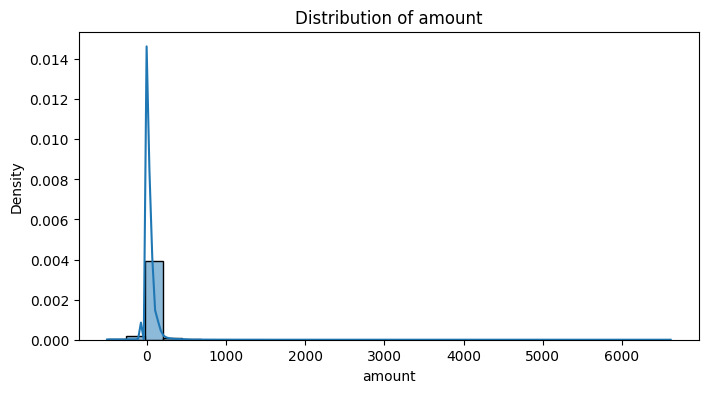


Descriptive Statistics for current_age:
count    8.480820e+06
mean     5.403972e+01
std      1.571712e+01
min      2.300000e+01
25%      4.200000e+01
50%      5.200000e+01
75%      6.300000e+01
max      1.010000e+02
Name: current_age, dtype: float64
Skewness = 0.55, Kurtosis = -0.28


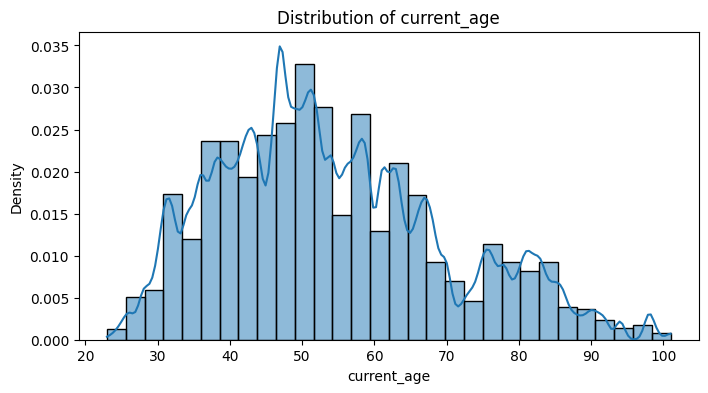


Descriptive Statistics for retirement_age:
count    8.480820e+06
mean     6.648717e+01
std      3.587385e+00
min      5.300000e+01
25%      6.500000e+01
50%      6.600000e+01
75%      6.800000e+01
max      7.900000e+01
Name: retirement_age, dtype: float64
Skewness = -0.32, Kurtosis = 1.38


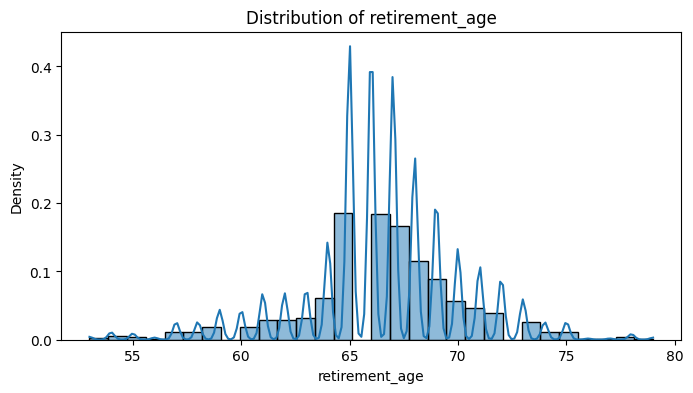


Descriptive Statistics for birth_year:
count    8.480820e+06
mean     1.965142e+03
std      1.570619e+01
min      1.918000e+03
25%      1.956000e+03
50%      1.968000e+03
75%      1.977000e+03
max      1.996000e+03
Name: birth_year, dtype: float64
Skewness = -0.55, Kurtosis = -0.27


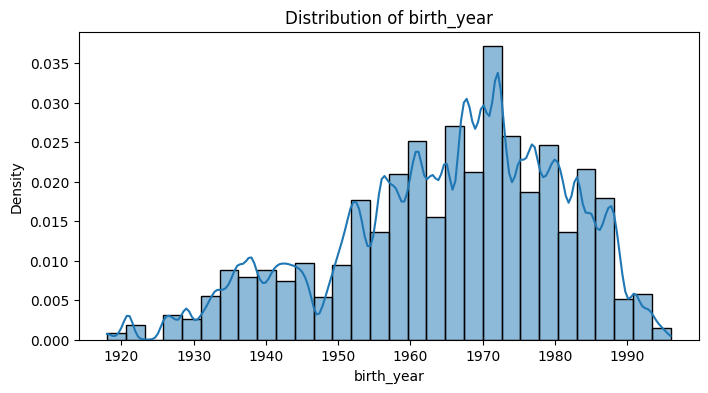


Descriptive Statistics for birth_month:
count    8.480820e+06
mean     6.567170e+00
std      3.605185e+00
min      1.000000e+00
25%      3.000000e+00
50%      7.000000e+00
75%      1.000000e+01
max      1.200000e+01
Name: birth_month, dtype: float64
Skewness = -0.03, Kurtosis = -1.34


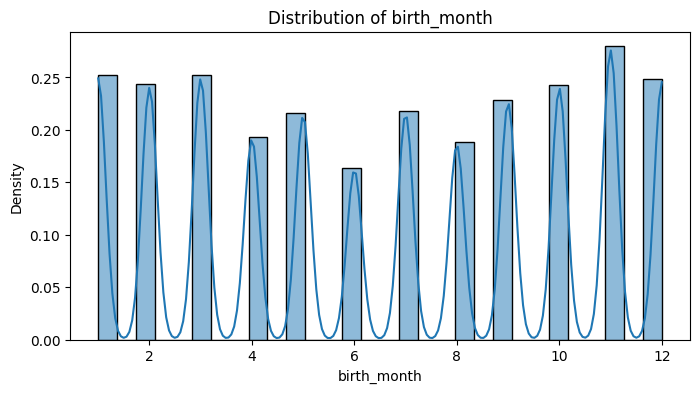


Descriptive Statistics for latitude:
count    8.480820e+06
mean     3.737446e+01
std      5.092880e+00
min      2.130000e+01
25%      3.389000e+01
50%      3.835000e+01
75%      4.112000e+01
max      4.853000e+01
Name: latitude, dtype: float64
Skewness = -0.40, Kurtosis = -0.28


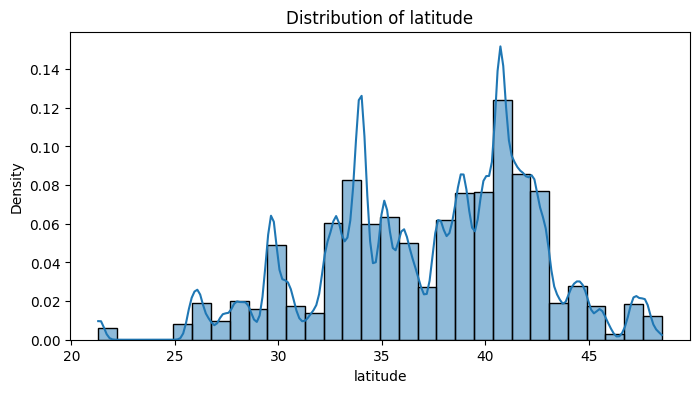


Descriptive Statistics for longitude:
count    8.480820e+06
mean    -9.156576e+01
std      1.625846e+01
min     -1.581800e+02
25%     -9.737000e+01
50%     -8.647000e+01
75%     -8.012000e+01
max     -6.867000e+01
Name: longitude, dtype: float64
Skewness = -1.03, Kurtosis = 0.51


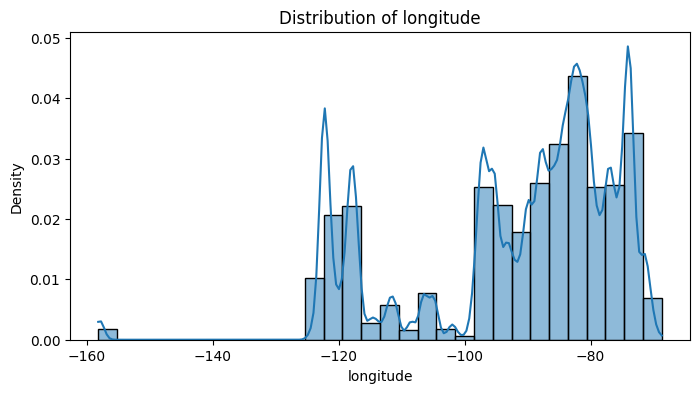


Descriptive Statistics for per_capita_income:
count    8.480820e+06
mean     2.398150e+04
std      1.197131e+04
min      0.000000e+00
25%      1.711300e+04
50%      2.115600e+04
75%      2.730800e+04
max      1.631450e+05
Name: per_capita_income, dtype: float64
Skewness = 3.72, Kurtosis = 26.25


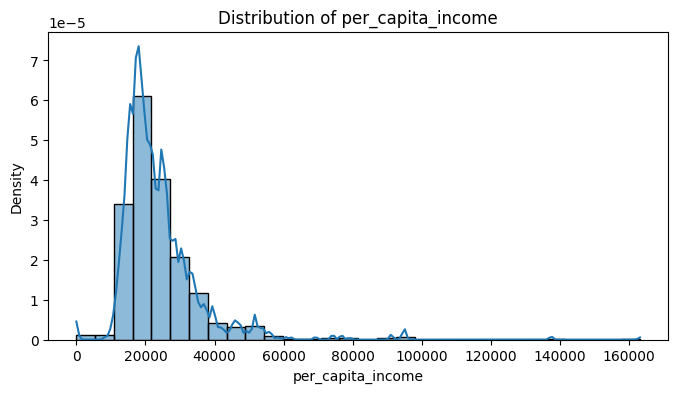


Descriptive Statistics for yearly_income:
count    8.480820e+06
mean     4.668666e+04
std      2.444893e+04
min      1.000000e+00
25%      3.281700e+04
50%      4.106900e+04
75%      5.401300e+04
max      2.801990e+05
Name: yearly_income, dtype: float64
Skewness = 3.11, Kurtosis = 18.09


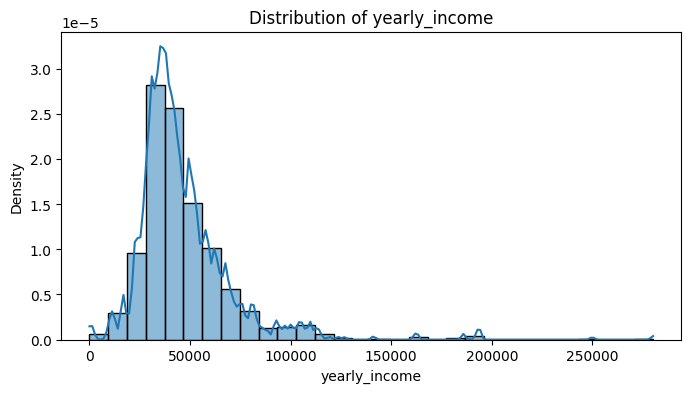


Descriptive Statistics for total_debt:
count    8.480820e+06
mean     5.800131e+04
std      5.206335e+04
min      0.000000e+00
25%      1.643700e+04
50%      5.167900e+04
75%      8.516000e+04
max      4.618540e+05
Name: total_debt, dtype: float64
Skewness = 1.74, Kurtosis = 7.05


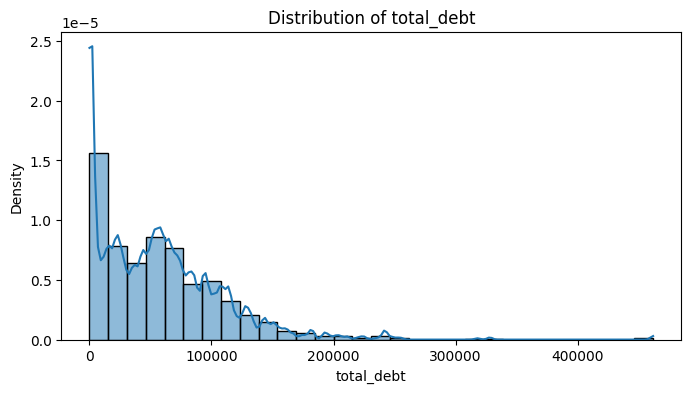


Descriptive Statistics for credit_score:
count    8.480820e+06
mean     7.139177e+02
std      6.581107e+01
min      4.880000e+02
25%      6.840000e+02
50%      7.160000e+02
75%      7.560000e+02
max      8.500000e+02
Name: credit_score, dtype: float64
Skewness = -0.60, Kurtosis = 0.82


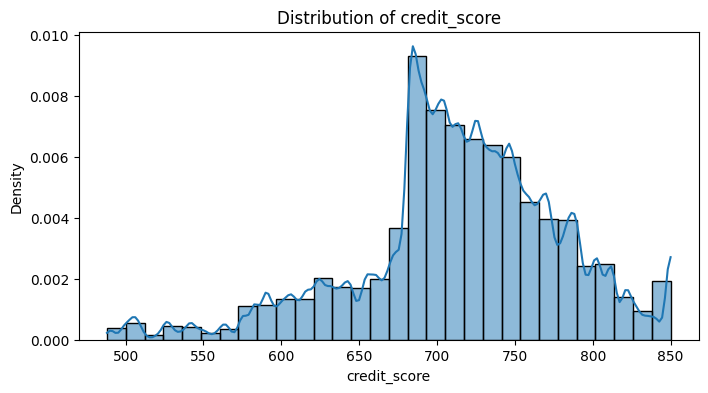


Descriptive Statistics for num_credit_cards:
count    8.480820e+06
mean     3.841614e+00
std      1.567770e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      5.000000e+00
max      9.000000e+00
Name: num_credit_cards, dtype: float64
Skewness = 0.31, Kurtosis = -0.08


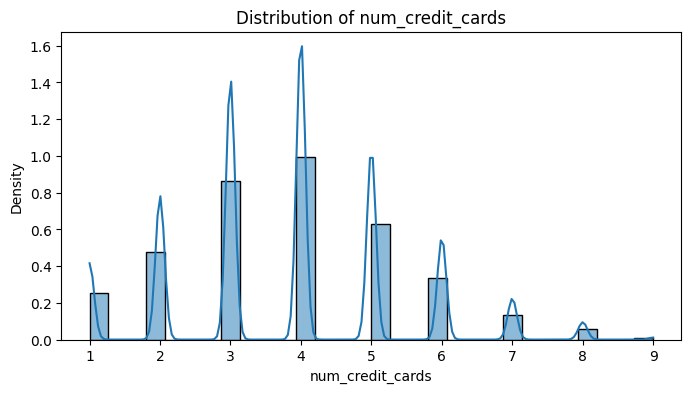


Descriptive Statistics for num_cards_issued:
count    8.480820e+06
mean     1.521845e+00
std      5.151139e-01
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      2.000000e+00
max      3.000000e+00
Name: num_cards_issued, dtype: float64
Skewness = 0.09, Kurtosis = -1.58


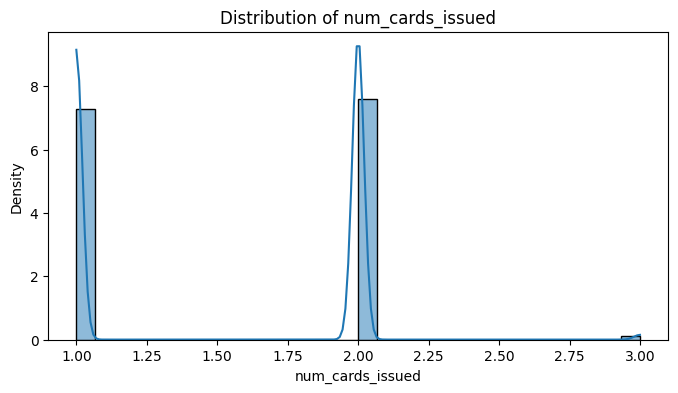


Descriptive Statistics for credit_limit:
count    8.480820e+06
mean     1.554146e+04
std      1.217967e+04
min      0.000000e+00
25%      8.100000e+03
50%      1.345200e+04
75%      2.083900e+04
max      1.413910e+05
Name: credit_limit, dtype: float64
Skewness = 2.43, Kurtosis = 14.60


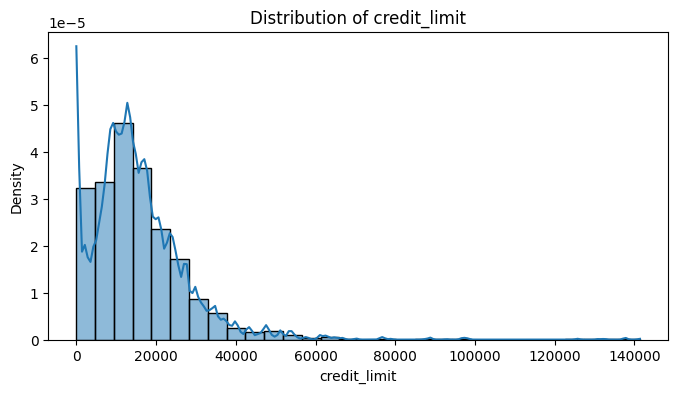


Descriptive Statistics for year_pin_last_changed:
count    8.480820e+06
mean     2.011315e+03
std      2.881395e+00
min      2.002000e+03
25%      2.010000e+03
50%      2.011000e+03
75%      2.013000e+03
max      2.020000e+03
Name: year_pin_last_changed, dtype: float64
Skewness = 0.37, Kurtosis = 0.32


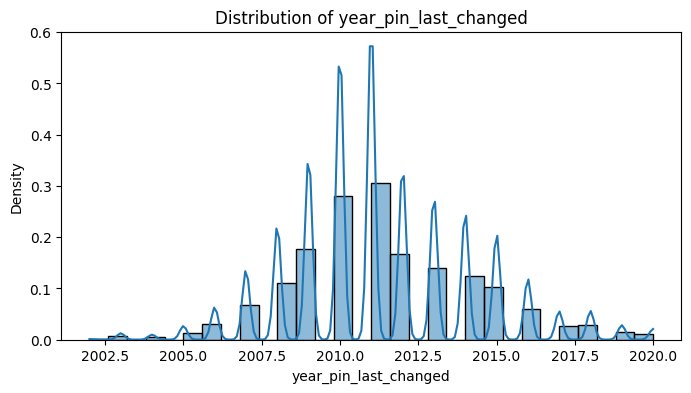


Descriptive Statistics for account_age_months:
count    8.480820e+06
mean     8.365871e+01
std      5.284895e+01
min     -1.800000e+01
25%      4.200000e+01
50%      7.800000e+01
75%      1.170000e+02
max      3.400000e+02
Name: account_age_months, dtype: float64
Skewness = 0.64, Kurtosis = 0.14


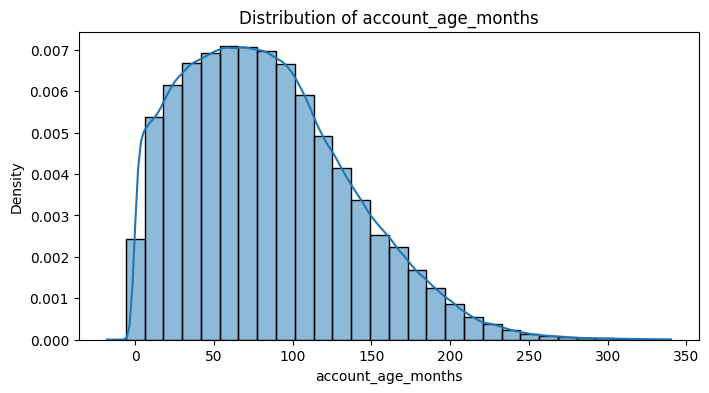


Descriptive Statistics for months_until_expiry:
count    8.480820e+06
mean     8.520490e+01
std      3.925064e+01
min     -1.000000e+00
25%      5.600000e+01
50%      8.400000e+01
75%      1.150000e+02
max      1.790000e+02
Name: months_until_expiry, dtype: float64
Skewness = 0.03, Kurtosis = -0.74


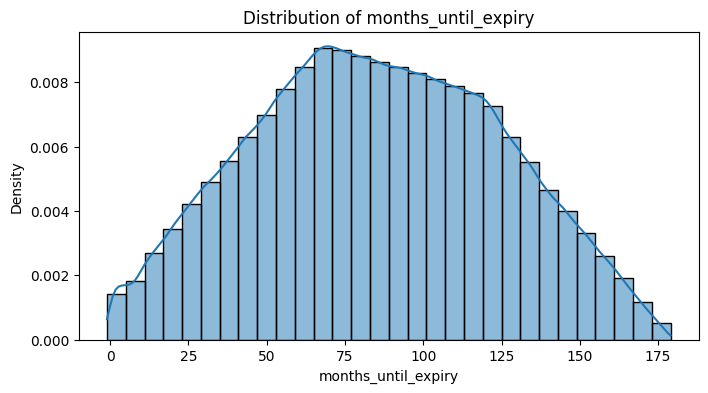


Descriptive Statistics for years_since_pin_changed:
count    8.480820e+06
mean     4.003588e+00
std      4.244023e+00
min      0.000000e+00
25%      0.000000e+00
50%      3.000000e+00
75%      7.000000e+00
max      2.500000e+01
Name: years_since_pin_changed, dtype: float64
Skewness = 1.06, Kurtosis = 0.60


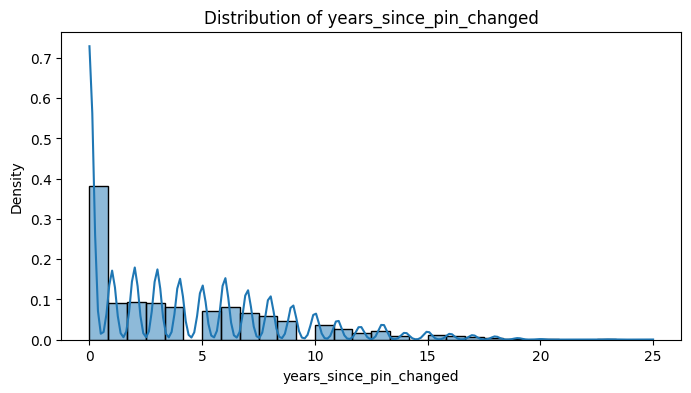

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



# Define numerical columns based on your dtype list
numerical_cols = [
    'amount', 'current_age', 'retirement_age', 'birth_year', 'birth_month', 
    'latitude', 'longitude', 'per_capita_income', 'yearly_income', 'total_debt',
    'credit_score', 'num_credit_cards', 'num_cards_issued', 'credit_limit',
    'year_pin_last_changed', 'account_age_months', 'months_until_expiry', 
    'years_since_pin_changed', 
    
]

# --- Numerical Columns Distribution ---
print("Distribution Analysis for Numerical Columns:")
for col in numerical_cols:
    if col in final_df.columns:
        # Descriptive statistics
        print(f"\nDescriptive Statistics for {col}:")
        print(df[col].describe())
        
        # Skewness and Kurtosis
        skewness = final_df[col].skew()
        kurtosis = final_df[col].kurtosis()
        print(f"Skewness = {skewness:.2f}, Kurtosis = {kurtosis:.2f}")
        
        # Histogram with KDE
        plt.figure(figsize=(8, 4))
        sns.histplot(final_df[col].dropna(), bins=30, kde=True, stat='density')
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Density')
        plt.show()
    else:
        print(f"{col} not found in DataFrame")

- We can observe certain features are right, left and almost normally distributed.

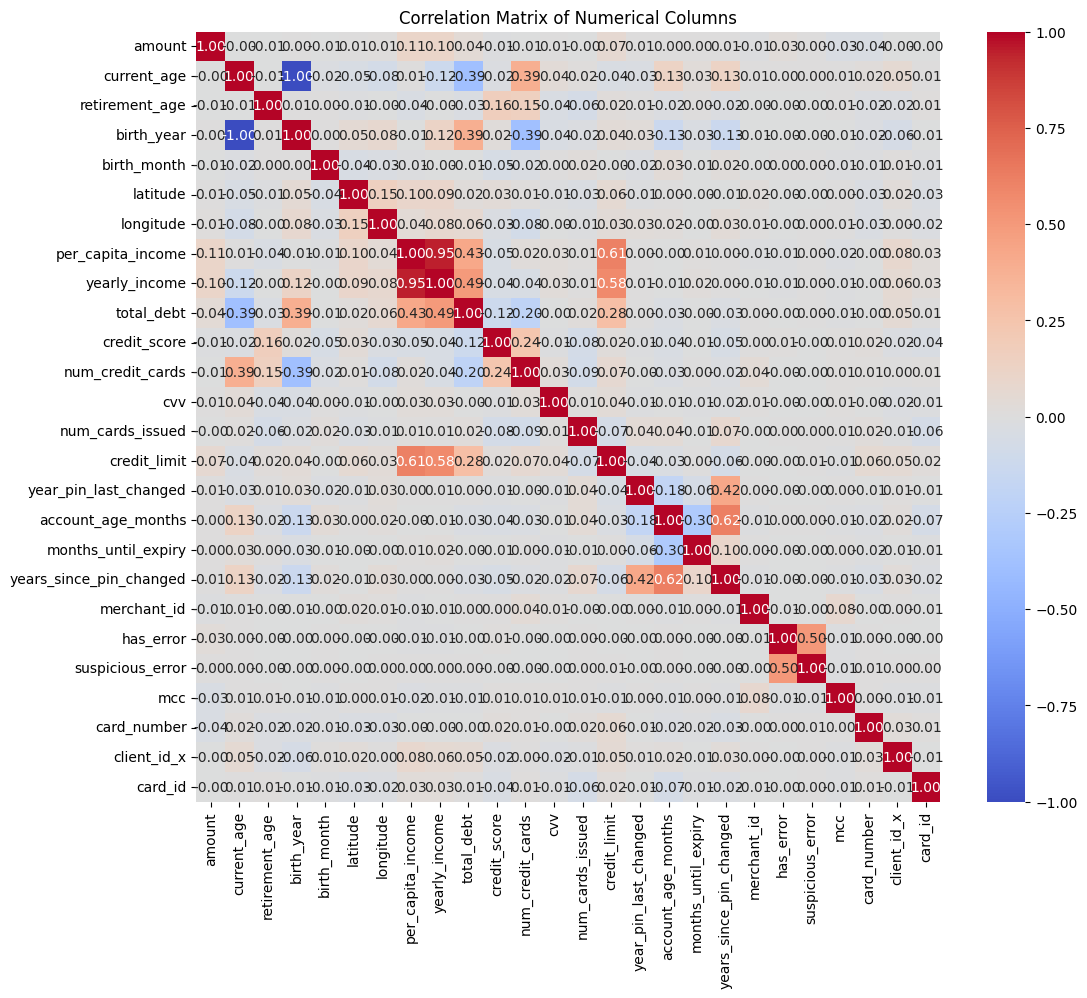

In [9]:
# Let's check for correlation between features
numerical_cols = [
    'amount', 'current_age', 'retirement_age', 'birth_year', 'birth_month', 
    'latitude', 'longitude', 'per_capita_income', 'yearly_income', 'total_debt',
    'credit_score', 'num_credit_cards', 'cvv', 'num_cards_issued', 'credit_limit',
    'year_pin_last_changed', 'account_age_months', 'months_until_expiry', 
    'years_since_pin_changed', 'merchant_id', 'has_error', 'suspicious_error', 
    'mcc', 'card_number', 'client_id_x', 'card_id'
]

corr_matrix = final_df[numerical_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical Columns')
plt.show()

In [11]:
# Let's remove one of the two columns which is highly correlated
threshold = 0.8
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

print(high_corr_pairs)

[('current_age', 'birth_year', -0.9996989237856497), ('per_capita_income', 'yearly_income', 0.9493619232033956)]


- The pairs (current_age and birth_year), (per_capita_income and yearly_income) are highly correlated

In [15]:
# Let's confirm the correlation of these features each other by comparing with 'fraud label'
for col in ['per_capita_income', 'yearly_income']:
    corr = final_df[[col, 'fraud_label']].corr().iloc[0, 1]
    print(f"{col} correlation with fraud_label: {corr:.3f}")

print("-"*50)

for col in ["current_age", "birth_year"]:
    corr = final_df[[col, "fraud_label"]].corr().iloc[0, 1]
    print(f"{col} correlation with fraud_label: {corr:.3f}")

per_capita_income correlation with fraud_label: -0.004
yearly_income correlation with fraud_label: -0.004
--------------------------------------------------
current_age correlation with fraud_label: 0.004
birth_year correlation with fraud_label: -0.004


- The magnitude of these features are equal to each other, so we remove one of them in each pair

In [18]:
# Removing 'birth_year, per_capita_income' features 
final_df.drop(columns=["birth_year", "per_capita_income"], axis=1, inplace=True) 


In [19]:
final_df.to_csv("new_base.csv")

In [2]:
final_df = pd.read_csv("base.csv")

In [3]:
final_df.columns

Index(['Unnamed: 0', 'date', 'client_id_x', 'card_id', 'amount', 'use_chip',
       'merchant_id', 'merchant_city', 'merchant_state', 'mcc', 'mcc_name',
       'fraud_label', 'has_error', 'suspicious_error', 'current_age',
       'retirement_age', 'birth_year', 'birth_month', 'gender', 'address',
       'latitude', 'longitude', 'per_capita_income', 'yearly_income',
       'total_debt', 'credit_score', 'num_credit_cards', 'card_brand',
       'card_type', 'card_number', 'expires', 'cvv', 'has_chip',
       'num_cards_issued', 'credit_limit', 'acct_open_date',
       'year_pin_last_changed', 'account_age_months', 'months_until_expiry',
       'years_since_pin_changed'],
      dtype='object')